In [1]:
from util import stan_cache

In [2]:
import arviz as az

In [3]:
update_mpl_setting()

In [4]:
np.random.seed(1234)

In [5]:
a = np.random.poisson(lam=10, size=40) 
b = np.random.poisson(lam=7, size=30) 
sample = np.hstack((a, b))
n = len(sample)

<BarContainer object of 70 artists>

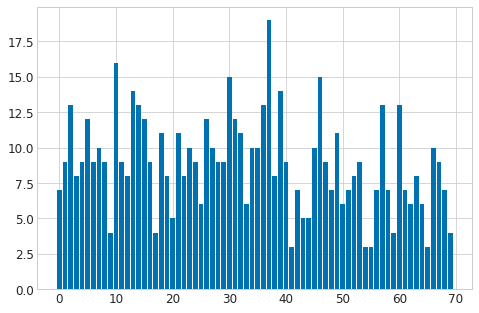

In [6]:
plt.bar(np.arange(n), sample)

In [7]:
model = """
data {
    int<lower=0> N;
    int<lower=0> c[N];
    real<lower=0> a;
    real<lower=0> b;
}
transformed data {
    real log_unif;
    log_unif = -log(N);
}
parameters {
    real<lower=0> lambda1;
    real<lower=0> lambda2;
}
transformed parameters {
    vector[N] lp;
    lp = rep_vector(log_unif, N);
    for (cp in 1:N) {
        for (t in 1:N) {
            lp[cp] = lp[cp] + poisson_log(c[t], if_else(t <= cp, lambda1, lambda2));
        }
    }
}
model {
    lambda1~ gamma(a, b);
    lambda2 ~ gamma(a, b);
    target += log_sum_exp(lp);
}
generated quantities {
    int<lower=1, upper=N> tau;
    tau = categorical_rng(softmax(lp));
}
"""

In [8]:
data = {
    'N': len(sample),
    'c':  sample,
    'a': 2.0,
    'b': 0.1
}

sm = stan_cache(model_code=model)
params = sm.sampling(data=data, iter=6000, warmup=1000)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9cae7d4fd36cbcea169f1a0c9a8ceea1 NOW.


In [9]:
pd.DataFrame({'lambda1': params['lambda1'], 'lambda2': params['lambda2'], 'tau': params['tau']}).describe().T

,count,mean,std,min,25%,50%,75%,max
lambda1,20000.0,9.831775,0.542073,7.208733,9.455097,9.818669,10.189008,12.483793
lambda2,20000.0,7.370717,0.793920,1.967969,6.970430,7.359469,7.753415,49.986550
tau,20000.0,43.978050,7.174005,1.000000,40.000000,41.000000,49.000000,70.000000


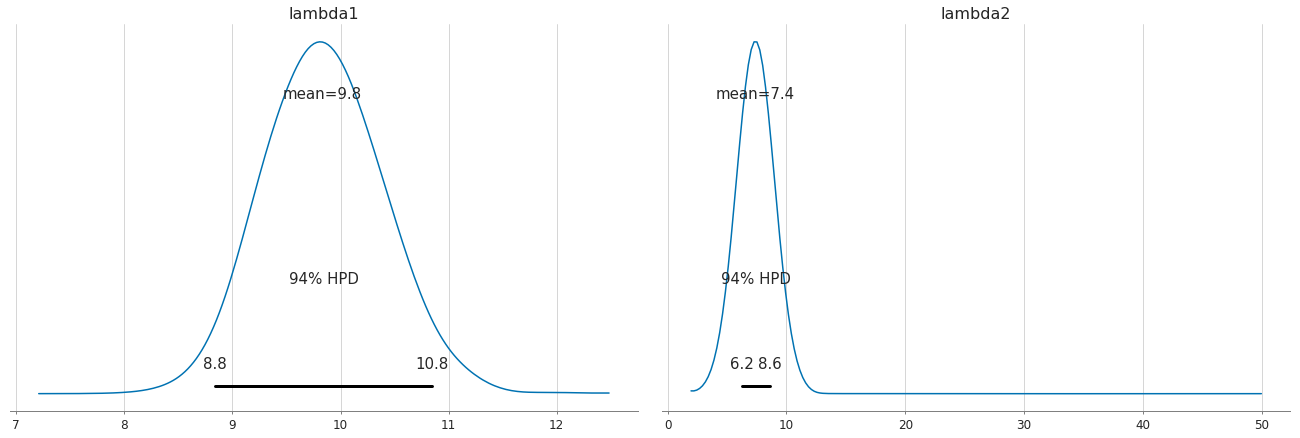

In [10]:
az.plot_posterior(params, var_names=['lambda1', 'lambda2']);

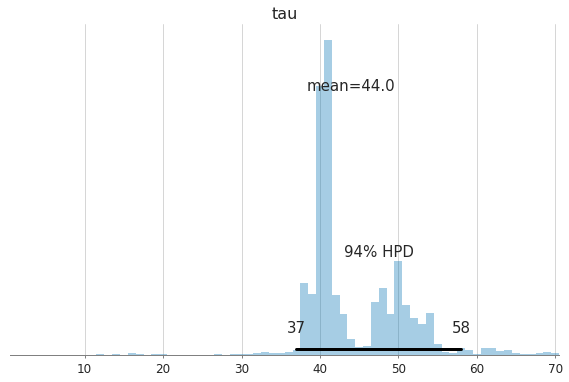

In [11]:
az.plot_posterior(params, var_names=['tau']);

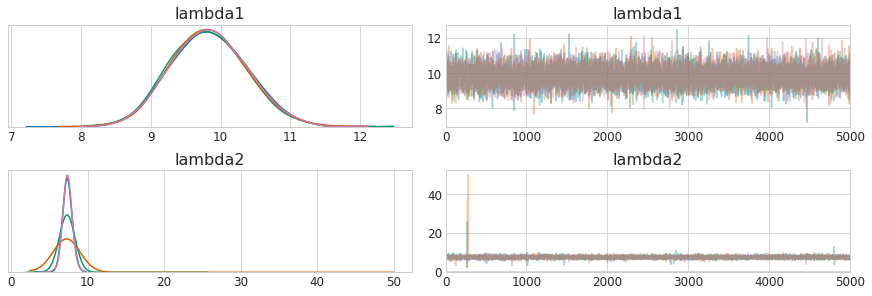

In [12]:
az.plot_trace(params, var_names=('lambda1', 'lambda2'));

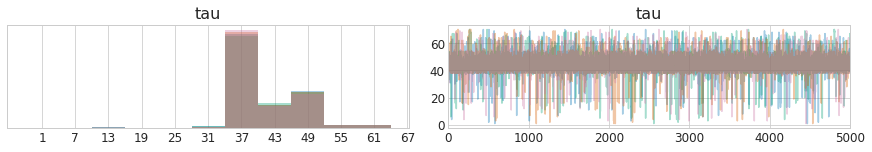

In [13]:
az.plot_trace(params, var_names=('tau'));